## Import Library

In [1]:
import pandas as pd
import numpy as np

#去除停頓詞
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import spacy  #要先下載好model
from nltk import word_tokenize

#文字轉向量
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models.word2vec import Word2Vec
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Split train test set
from sklearn.model_selection import train_test_split

#Create model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool2D, MaxPooling1D, Flatten
from keras.layers import ZeroPadding2D, Activation
from keras.layers.embeddings import Embedding 
from keras.layers import LSTM
from tensorflow import keras

#plot
import matplotlib.pyplot as plt

#評估模型好壞
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics


In [2]:
#關閉煩人的警告視窗!!!!!
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./archive/yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


## Data Prepocessing 

a. 讀取資料僅保留 'text' 與 'star' 兩個欄位

In [5]:
df = df[['stars', 'text']]
df.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


將stars欄位內值大於等於4的轉成1，其餘轉成0

1: positive

0: negative

In [6]:
df.stars[df.stars<4] = 0
df.stars[df.stars>=4] = 1
df.head(20)

,stars,text
0,1,My wife took me here on my birthday for breakf...
1,1,I have no idea why some people give bad review...
2,1,love the gyro plate. Rice is so good and I als...
3,1,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,1,General Manager Scott Petello is a good egg!!!...
5,1,"Quiessence is, simply put, beautiful. Full wi..."
6,1,Drop what you're doing and drive here. After I...
7,1,"Luckily, I didn't have to travel far to make m..."
8,1,Definitely come for Happy hour! Prices are ama...
9,1,Nobuo shows his unique talents with everything...


建立train&test之DataFrame 
80%為train，20%為test

b. 去除停頓詞stop words 

In [7]:
#用 Python NLP 中的 spacy 進行stopwords 處理
#先看一下spacy中有哪些停頓詞
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('spaCy has {} stop words'.format(len(spacy_stopwords)))
print('The first twenty stop words are {}'.format(list(spacy_stopwords)[:20]))

spaCy has 326 stop words
The first twenty stop words are ['own', 'beforehand', '’ve', 'hereby', 'elsewhere', 'nothing', 'much', "'ll", 'the', 'around', 'or', 'doing', 'namely', 'latter', 'must', "'m", 'bottom', 'we', 'they', 'such']


In [8]:
"""
1. imdb_df['text'].apply將每個row的text值分別取出
2. apply(lambda x: rmsw_function(x, spacy_stopwords)) 這邊可以拆解成
    - 將imdb_df['text'] 取出，當作lambda function的 x
    - 然後丟進 rmsw_function 得到ruturn的值
    - 然後放到 imdb['spacy_rmsw_text_fancy']之中
"""
#nltk.download('punkt')
#def rmsw_function(text, stopword_list):
#    return ' '.join([word for word in word_tokenize(text) if word not in stopword_list])
#df1['rmsw_text'] = df1['text'].apply(lambda x: rmsw_function(x, spacy_stopwords))
df['rmsw_text'] =  df['text'].apply(lambda x:' '.join([word for word in x.split() if word not in spacy_stopwords]))

In [9]:
df['rmsw_text'][0]

'My wife took birthday breakfast excellent. The weather perfect sitting outside overlooking grounds absolute pleasure. Our waitress excellent food arrived quickly semi-busy Saturday morning. It looked like place fills pretty quickly earlier better. Do favor Bloody Mary. It phenomenal simply best I\'ve had. I\'m pretty sure use ingredients garden blend fresh order it. It amazing. While EVERYTHING menu looks excellent, I white truffle scrambled eggs vegetable skillet tasty delicious. It came 2 pieces griddled bread amazing absolutely meal complete. It best "toast" I\'ve had. Anyway, I can\'t wait back!'

In [10]:
df['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

c. 文字轉向量（Tfidf 、Ｗord2vec …等 ）

- 使用word2vec

In [11]:
tokenized_tweet = df['rmsw_text'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

In [12]:
model_w2v.build_vocab(tokenized_tweet, progress_per = 1000)
model_w2v.train(tokenized_tweet, total_examples =model_w2v.corpus_count, epochs = model_w2v.epochs)
model_w2v.save("./w2v_model")

In [13]:
model_w2v.wv.most_similar('bad')

[('terrible', 0.6536588668823242),
 ('ruined', 0.6119721531867981),
 ('awful', 0.6030116677284241),
 ('either.', 0.590649425983429),
 ('overall', 0.5905405879020691),
 ('ATM', 0.5867387056350708),
 ('poor', 0.5819487571716309),
 ('holidays,', 0.580440104007721),
 ("Smithwick's", 0.5802451968193054),
 ('tight,', 0.5768543481826782)]

In [14]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [15]:
#轉成array的形式等等丟model
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
# wordvec_df.shape
print(len(wordvec_arrays))

10000


In [16]:
wordvec_arrays

array([[-0.13584621, -0.39326147, -0.02013219, ..., -0.114064  ,
        -0.00995557,  0.11588292],
       [-0.14289475, -0.3858874 , -0.07713587, ..., -0.10378244,
        -0.01836114,  0.09059891],
       [-0.12860913, -0.18705917, -0.11625474, ..., -0.19848605,
         0.02641168,  0.06477737],
       ...,
       [-0.11757697, -0.35078612, -0.03676837, ..., -0.08084313,
         0.03819029,  0.13316212],
       [-0.08459394, -0.33114721, -0.06255296, ..., -0.07700969,
         0.03480771,  0.07993919],
       [-0.12675977, -0.3546756 , -0.03086532, ..., -0.09547755,
         0.04953005,  0.15336361]])

In [17]:
wordvec_arrays.shape

(10000, 200)

- 使用keras tokenizer

In [18]:
maxlen = 200
max_words = 10000
tokenizer = Tokenizer(num_words=1000)   #只考慮1000個最常用的詞
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])  
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'a': 4,
 'to': 5,
 'of': 6,
 'was': 7,
 'is': 8,
 'it': 9,
 'for': 10,
 'in': 11,
 'that': 12,
 'my': 13,
 'with': 14,
 'but': 15,
 'you': 16,
 'this': 17,
 'on': 18,
 'they': 19,
 'we': 20,
 'have': 21,
 'not': 22,
 'had': 23,
 'are': 24,
 'good': 25,
 'so': 26,
 'place': 27,
 'at': 28,
 'food': 29,
 'were': 30,
 'as': 31,
 'be': 32,
 'there': 33,
 'great': 34,
 'like': 35,
 'if': 36,
 'all': 37,
 'me': 38,
 'out': 39,
 'just': 40,
 'very': 41,
 'here': 42,
 'one': 43,
 'or': 44,
 'their': 45,
 'get': 46,
 "it's": 47,
 'from': 48,
 'up': 49,
 'go': 50,
 'when': 51,
 'time': 52,
 'really': 53,
 'our': 54,
 'about': 55,
 'some': 56,
 'service': 57,
 'would': 58,
 'an': 59,
 'what': 60,
 'been': 61,
 'can': 62,
 'which': 63,
 'your': 64,
 'back': 65,
 'more': 66,
 'only': 67,
 'will': 68,
 'also': 69,
 "don't": 70,
 'by': 71,
 'no': 72,
 'too': 73,
 'love': 74,
 "i'm": 75,
 'little': 76,
 'nice': 77,
 'has': 78,
 'well': 79,
 'other': 80,
 'because': 81,
 

padding 因為進行深度學習模型訓練時長度必須固定

In [19]:
# use pad_sequence to make traning samples the same size, fill with zeros
#長度小於200的 前面數字補0
#長度大於200的 截去前面的數字
data_input = pad_sequences(sequences, maxlen = maxlen)

In [20]:
data_input

array([[  0,   0,   0, ...,   5,  50,  65],
       [275,   2,   3, ..., 179,  21,  56],
       [  0,   0,   0, ...,  69,  45, 245],
       ...,
       [368,  78,  56, ...,   6,   1, 450],
       [  0,   0,   0, ...,   4,   4, 104],
       [  0,   0,   0, ...,  18,   1, 522]])

In [21]:
data_input.shape

(10000, 200)

## Split Training Set and Testing Set 

- 使用word2vec轉向量的方法

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)).fit(wordvec_arrays)
wordvec_arrays_scaled = scaler.transform(wordvec_arrays)

In [23]:
wordvec_arrays_scaled

array([[0.6473397 , 0.47065017, 0.58782789, ..., 0.53263432, 0.28868269,
        0.56589671],
       [0.63721388, 0.4791298 , 0.50621214, ..., 0.54805013, 0.27542788,
        0.52527595],
       [0.65773635, 0.70776728, 0.45020318, ..., 0.40605482, 0.3460305 ,
        0.4837916 ],
       ...,
       [0.67358496, 0.51949362, 0.56400882, ..., 0.58244455, 0.36460428,
        0.5936571 ],
       [0.72096779, 0.54207689, 0.52709141, ..., 0.58819228, 0.35927026,
        0.50815026],
       [0.66039311, 0.51502101, 0.5724606 , ..., 0.5605022 , 0.38248603,
        0.6261124 ]])

In [24]:
"""
indices = np.arange(wordvec_arrays.shape[0])
np.random.shuffle(indices)
wordvec_arrays = wordvec_arrays[indices]
df['stars'] = df.stars[indices]
"""

y = df['stars']
#x = wordvec_arrays_scaled
x = wordvec_arrays
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [25]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 200)
(2000, 200)
(8000,)
(2000,)


## Create Model

####  使用LSTM (有Dropout Layer)

In [26]:
max_words = 10000 
maxlen = 200
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64,input_length = maxlen))
model_lstm.add(Dropout(0.7))
model_lstm.add(LSTM(20,dropout=0.7, recurrent_dropout=0.7))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.7))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
dropout (Dropout)            (None, 200, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                6800      
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 652,433
Trainable params: 652,433
Non-trainable params: 0
__________________________________________________

In [27]:
#from keras.optimizers import SGD
#opt = SGD(lr=0.01, momentum=0.9, clipvalue=1)
opt = keras.optimizers.RMSprop(learning_rate=0.01)
model_lstm.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['acc'])

In [28]:
history_lstm = model_lstm.fit(x_train, y_train,epochs=9,batch_size=100,validation_split=0.2)

Epoch 1/9
64/64 [==============================] - 10s 161ms/step - loss: 0.6407 - acc: 0.6758 - val_loss: 0.6181 - val_acc: 0.6931
Epoch 2/9
64/64 [==============================] - 10s 160ms/step - loss: 0.6337 - acc: 0.6795 - val_loss: 0.6187 - val_acc: 0.6931
Epoch 3/9
64/64 [==============================] - 10s 154ms/step - loss: 0.6332 - acc: 0.6798 - val_loss: 0.6252 - val_acc: 0.6931
Epoch 4/9
64/64 [==============================] - 10s 156ms/step - loss: 0.6309 - acc: 0.6798 - val_loss: 0.6194 - val_acc: 0.6931
Epoch 5/9
64/64 [==============================] - 12s 185ms/step - loss: 0.6314 - acc: 0.6798 - val_loss: 0.6198 - val_acc: 0.6931
Epoch 6/9
64/64 [==============================] - 11s 176ms/step - loss: 0.6320 - acc: 0.6798 - val_loss: 0.6235 - val_acc: 0.6931
Epoch 7/9
64/64 [==============================] - 13s 199ms/step - loss: 0.6306 - acc: 0.6798 - val_loss: 0.6194 - val_acc: 0.6931
Epoch 8/9
64/64 [==============================] - 12s 191ms/step - loss: 0.

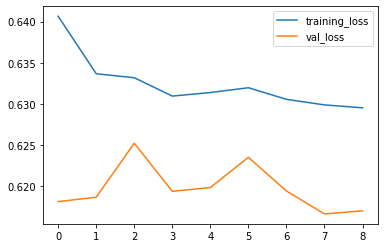

In [29]:
#plot model loss
plt.plot(history_lstm.history['loss'], label = 'training_loss')
plt.plot(history_lstm.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

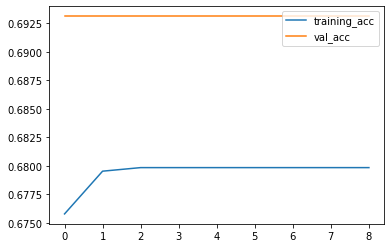

In [30]:
#plot model loss
plt.plot(history_lstm.history['acc'], label = 'training_acc')
plt.plot(history_lstm.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

####  使用LSTM (沒有Dropout Layer)

In [31]:
max_words = 10000 
maxlen = 200
model_lstm_w = Sequential()
model_lstm_w.add(Embedding(max_words, 64,input_length = maxlen))
model_lstm_w.add(LSTM(10))
model_lstm_w.add(Dense(10, activation='relu'))
model_lstm_w.add(Dense(1, activation='sigmoid'))
model_lstm_w.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 643,121
Trainable params: 643,121
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.optimizers import SGD
#opt = SGD(lr=0.01, momentum=0.9, clipvalue=1)
opt = keras.optimizers.RMSprop(learning_rate=0.01)
model_lstm_w.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [33]:
history_lstm_w = model_lstm_w.fit(x_train, y_train,epochs=6,batch_size=120,validation_split=0.2)

Epoch 1/6
54/54 [==============================] - 6s 112ms/step - loss: 0.6331 - acc: 0.6798 - val_loss: 0.6172 - val_acc: 0.6931
Epoch 2/6
54/54 [==============================] - 5s 90ms/step - loss: 0.6271 - acc: 0.6798 - val_loss: 0.6213 - val_acc: 0.6931
Epoch 3/6
54/54 [==============================] - 4s 82ms/step - loss: 0.6295 - acc: 0.6798 - val_loss: 0.6166 - val_acc: 0.6931
Epoch 4/6
54/54 [==============================] - 5s 95ms/step - loss: 0.6272 - acc: 0.6798 - val_loss: 0.6202 - val_acc: 0.6931
Epoch 5/6
54/54 [==============================] - 5s 97ms/step - loss: 0.6274 - acc: 0.6798 - val_loss: 0.6172 - val_acc: 0.6931
Epoch 6/6
54/54 [==============================] - 5s 92ms/step - loss: 0.6281 - acc: 0.6798 - val_loss: 0.6181 - val_acc: 0.6931


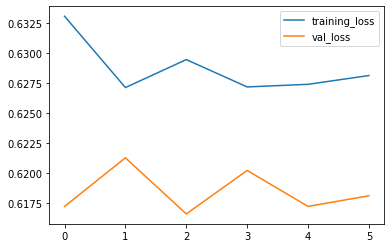

In [34]:
#plot model loss
plt.plot(history_lstm_w.history['loss'], label = 'training_loss')
plt.plot(history_lstm_w.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

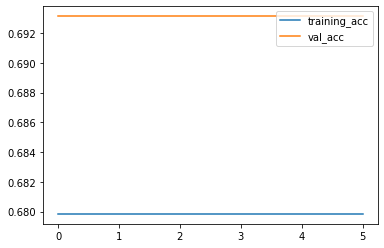

In [35]:
#plot model loss
plt.plot(history_lstm_w.history['acc'], label = 'training_acc')
plt.plot(history_lstm_w.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

#### 使用CNN (有Dropout Layer)

In [36]:
# define model
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 64, input_length=maxlen))
model_cnn.add(Dropout(0.7))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
model_cnn.add(Dropout(0.7))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.7))
model_cnn.add(Dense(5, activation='relu'))
model_cnn.add(Dropout(0.7))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 193, 64)           32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 193, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6144)             

In [37]:
model_cnn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [38]:
history_cnn = model_cnn.fit(x_train, y_train,
                    epochs=15,
                    batch_size=100,
                    validation_split=0.2)

Epoch 1/15
64/64 [==============================] - 6s 98ms/step - loss: 0.6707 - acc: 0.6723 - val_loss: 0.6638 - val_acc: 0.6931
Epoch 2/15
64/64 [==============================] - 6s 95ms/step - loss: 0.6610 - acc: 0.6797 - val_loss: 0.6600 - val_acc: 0.6931
Epoch 3/15
64/64 [==============================] - 6s 94ms/step - loss: 0.6512 - acc: 0.6798 - val_loss: 0.6492 - val_acc: 0.6931
Epoch 4/15
64/64 [==============================] - 6s 95ms/step - loss: 0.6459 - acc: 0.6798 - val_loss: 0.6465 - val_acc: 0.6931
Epoch 5/15
64/64 [==============================] - 6s 95ms/step - loss: 0.6430 - acc: 0.6798 - val_loss: 0.6400 - val_acc: 0.6931
Epoch 6/15
64/64 [==============================] - 6s 96ms/step - loss: 0.6420 - acc: 0.6798 - val_loss: 0.6394 - val_acc: 0.6931
Epoch 7/15
64/64 [==============================] - 7s 108ms/step - loss: 0.6396 - acc: 0.6798 - val_loss: 0.6318 - val_acc: 0.6931
Epoch 8/15
64/64 [==============================] - 8s 127ms/step - loss: 0.6357 -

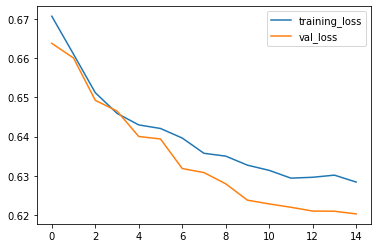

In [39]:
#plot model loss
plt.plot(history_cnn.history['loss'], label = 'training_loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

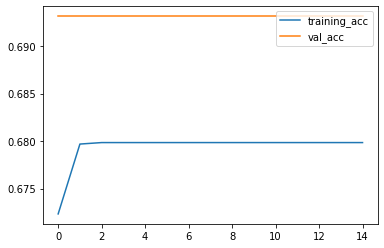

In [40]:
#plot model loss
plt.plot(history_cnn.history['acc'], label = 'training_acc')
plt.plot(history_cnn.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

#### 使用CNN (沒有Dropout Layer)

In [41]:
# define model
model_cnn_w = Sequential()
model_cnn_w.add(Embedding(max_words, 32, input_length=maxlen))
model_cnn_w.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model_cnn_w.add(MaxPooling1D(pool_size=2))
model_cnn_w.add(Flatten())
model_cnn_w.add(Dense(5, activation='relu'))
model_cnn_w.add(Dense(1, activation='sigmoid'))
model_cnn_w.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 32)           8224      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 15365     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 343,595
Trainable params: 343,595
Non-trainable params: 0
________________________________________________

In [42]:
model_cnn_w.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [43]:
history_cnn_w = model_cnn_w.fit(x_train, y_train,
                    epochs=15,
                    batch_size=100,
                    validation_split=0.2)

Epoch 1/15
64/64 [==============================] - 2s 32ms/step - loss: 0.6330 - acc: 0.6742 - val_loss: 0.6204 - val_acc: 0.6931
Epoch 2/15
64/64 [==============================] - 2s 28ms/step - loss: 0.6291 - acc: 0.6798 - val_loss: 0.6185 - val_acc: 0.6931
Epoch 3/15
64/64 [==============================] - 2s 29ms/step - loss: 0.6287 - acc: 0.6798 - val_loss: 0.6240 - val_acc: 0.6931
Epoch 4/15
64/64 [==============================] - 2s 28ms/step - loss: 0.6283 - acc: 0.6798 - val_loss: 0.6166 - val_acc: 0.6931
Epoch 5/15
64/64 [==============================] - 2s 28ms/step - loss: 0.6287 - acc: 0.6798 - val_loss: 0.6166 - val_acc: 0.6931
Epoch 6/15
64/64 [==============================] - 2s 30ms/step - loss: 0.6286 - acc: 0.6798 - val_loss: 0.6180 - val_acc: 0.6931
Epoch 7/15
64/64 [==============================] - 2s 30ms/step - loss: 0.6281 - acc: 0.6798 - val_loss: 0.6175 - val_acc: 0.6931
Epoch 8/15
64/64 [==============================] - 2s 29ms/step - loss: 0.6282 - a

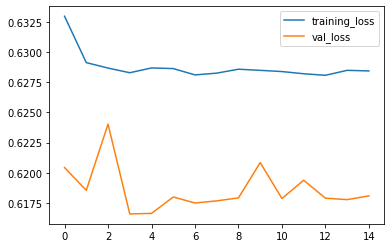

In [44]:
#plot model loss
plt.plot(history_cnn_w.history['loss'], label = 'training_loss')
plt.plot(history_cnn_w.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

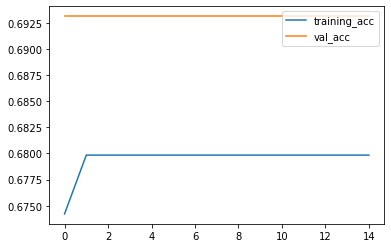

In [45]:
#plot model loss
plt.plot(history_cnn_w.history['acc'], label = 'training_acc')
plt.plot(history_cnn_w.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

## Evaluate Model 

In [46]:
model_lstm.evaluate(x_test, y_test)

63/63 [==============================] - 1s 22ms/step - loss: 0.6107 - acc: 0.7015


[0.6106881499290466, 0.7014999985694885]

In [47]:
model_lstm_w.evaluate(x_test, y_test)

63/63 [==============================] - 1s 15ms/step - loss: 0.6123 - acc: 0.7015


[0.6122620701789856, 0.7014999985694885]

In [48]:
model_cnn.evaluate(x_test, y_test)

63/63 [==============================] - 0s 6ms/step - loss: 0.6150 - acc: 0.7015


[0.614971399307251, 0.7014999985694885]

In [49]:
model_cnn_w.evaluate(x_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.6123 - acc: 0.7015


[0.612251877784729, 0.7014999985694885]

- 使用Tokenizer轉向量的方法

In [50]:
y = df['stars']
x = data_input
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

In [51]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 200)
(2000, 200)
(8000,)
(2000,)


####  使用LSTM (有Dropout Layer)

In [52]:
max_words = 1000 
maxlen = 200
model_lstm = Sequential()
model_lstm.add(Embedding(output_dim = 64,input_dim = max_words,input_length = maxlen))
model_lstm.add(Dropout(0.7))
model_lstm.add(LSTM(10,dropout=0.7))
model_lstm.add(Dense(10,activation = 'relu'))
model_lstm.add(Dropout(0.7))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 64)           64000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 67,121
Trainable params: 67,121
Non-trainable params: 0
__________________________________________________

In [53]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
model_lstm.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [54]:
history_lstm = model_lstm.fit(x_train, y_train,
                    epochs=18,
                    batch_size=110,
                    validation_split=0.2)

Epoch 1/18
59/59 [==============================] - 10s 162ms/step - loss: 0.6719 - acc: 0.6581 - val_loss: 0.6291 - val_acc: 0.6931
Epoch 2/18
59/59 [==============================] - 8s 134ms/step - loss: 0.6448 - acc: 0.6798 - val_loss: 0.6202 - val_acc: 0.6931
Epoch 3/18
59/59 [==============================] - 6s 108ms/step - loss: 0.6327 - acc: 0.6798 - val_loss: 0.5974 - val_acc: 0.6931
Epoch 4/18
59/59 [==============================] - 6s 105ms/step - loss: 0.5992 - acc: 0.6928 - val_loss: 0.5473 - val_acc: 0.7175
Epoch 5/18
59/59 [==============================] - 6s 104ms/step - loss: 0.5621 - acc: 0.7272 - val_loss: 0.4862 - val_acc: 0.7806
Epoch 6/18
59/59 [==============================] - 6s 109ms/step - loss: 0.5364 - acc: 0.7552 - val_loss: 0.4797 - val_acc: 0.7744
Epoch 7/18
59/59 [==============================] - 8s 139ms/step - loss: 0.5158 - acc: 0.7631 - val_loss: 0.4550 - val_acc: 0.7825
Epoch 8/18
59/59 [==============================] - 7s 113ms/step - loss: 0

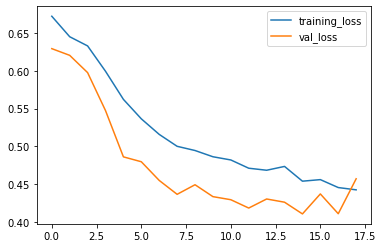

In [55]:
#plot model loss
plt.plot(history_lstm.history['loss'], label = 'training_loss')
plt.plot(history_lstm.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

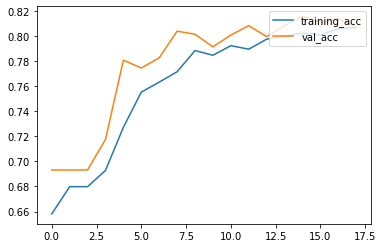

In [56]:
#plot model loss
plt.plot(history_lstm.history['acc'], label = 'training_acc')
plt.plot(history_lstm.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

In [57]:
model_lstm.evaluate(x_test, y_test)

63/63 [==============================] - 1s 13ms/step - loss: 0.4543 - acc: 0.8050


[0.4543452858924866, 0.8050000071525574]

####  使用LSTM (沒有Dropout Layer)

In [58]:
max_words = 1000 
maxlen = 200
model_lstm_w = Sequential()
model_lstm_w.add(Embedding(max_words, 32,input_length = maxlen))
model_lstm_w.add(LSTM(10))
model_lstm_w.add(Dense(10, activation='relu'))
model_lstm_w.add(Dense(1, activation='sigmoid'))
model_lstm_w.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 32)           32000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 33,841
Trainable params: 33,841
Non-trainable params: 0
_________________________________________________________________


In [59]:
from keras.optimizers import SGD
#opt = SGD(lr=0.01, momentum=0.9, clipvalue=1)
#opt = keras.optimizers.RMSprop(learning_rate=0.01)
model_lstm_w.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [60]:
history_lstm_w = model_lstm_w.fit(x_train, y_train,epochs=9,batch_size=100,validation_split=0.2)

Epoch 1/9
64/64 [==============================] - 4s 67ms/step - loss: 0.6300 - acc: 0.6744 - val_loss: 0.5828 - val_acc: 0.6931
Epoch 2/9
64/64 [==============================] - 3s 54ms/step - loss: 0.5270 - acc: 0.7156 - val_loss: 0.5025 - val_acc: 0.7606
Epoch 3/9
64/64 [==============================] - 3s 52ms/step - loss: 0.4371 - acc: 0.8070 - val_loss: 0.4570 - val_acc: 0.7850
Epoch 4/9
64/64 [==============================] - 4s 64ms/step - loss: 0.3819 - acc: 0.8367 - val_loss: 0.4377 - val_acc: 0.7819
Epoch 5/9
64/64 [==============================] - 4s 55ms/step - loss: 0.3544 - acc: 0.8514 - val_loss: 0.4382 - val_acc: 0.7825
Epoch 6/9
64/64 [==============================] - 3s 54ms/step - loss: 0.3385 - acc: 0.8586 - val_loss: 0.4403 - val_acc: 0.7969
Epoch 7/9
64/64 [==============================] - 4s 57ms/step - loss: 0.3214 - acc: 0.8658 - val_loss: 0.4476 - val_acc: 0.7969
Epoch 8/9
64/64 [==============================] - 4s 63ms/step - loss: 0.3122 - acc: 0.87

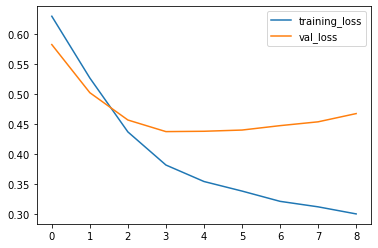

In [61]:
#plot model loss
plt.plot(history_lstm_w.history['loss'], label = 'training_loss')
plt.plot(history_lstm_w.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

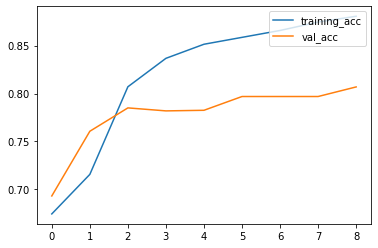

In [62]:
#plot model loss
plt.plot(history_lstm_w.history['acc'], label = 'training_acc')
plt.plot(history_lstm_w.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

In [63]:
model_lstm_w.evaluate(x_test, y_test)

63/63 [==============================] - 1s 14ms/step - loss: 0.4647 - acc: 0.8020


[0.46466922760009766, 0.8019999861717224]

#### 使用CNN (有Dropout Layer)

In [104]:
# define model
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 64, input_length=maxlen))
#model_cnn.add(Dropout(0.7))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model_cnn.add(Dropout(0.7))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.7))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.7))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 64)           64000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 197, 64)           16448     
_________________________________________________________________
dropout_18 (Dropout)         (None, 197, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)              

In [105]:
#opt = keras.optimizers.RMSprop(learning_rate=0.001)
#from keras.optimizers import SGD
#opt = SGD(lr=0.001, momentum=0.9, clipvalue=1)
model_cnn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [106]:
history_cnn = model_cnn.fit(x_train, y_train,
                    epochs=14,
                    batch_size=100,
                    validation_split=0.2)

Epoch 1/14
64/64 [==============================] - 4s 69ms/step - loss: 0.6397 - acc: 0.6767 - val_loss: 0.6318 - val_acc: 0.6931
Epoch 2/14
64/64 [==============================] - 4s 65ms/step - loss: 0.6278 - acc: 0.6800 - val_loss: 0.6050 - val_acc: 0.6931
Epoch 3/14
64/64 [==============================] - 4s 65ms/step - loss: 0.6040 - acc: 0.6803 - val_loss: 0.5622 - val_acc: 0.6931
Epoch 4/14
64/64 [==============================] - 4s 65ms/step - loss: 0.5330 - acc: 0.6998 - val_loss: 0.4820 - val_acc: 0.7513
Epoch 5/14
64/64 [==============================] - 5s 76ms/step - loss: 0.4830 - acc: 0.7663 - val_loss: 0.4470 - val_acc: 0.7975
Epoch 6/14
64/64 [==============================] - 5s 77ms/step - loss: 0.4431 - acc: 0.8000 - val_loss: 0.4327 - val_acc: 0.8081
Epoch 7/14
64/64 [==============================] - 5s 76ms/step - loss: 0.4264 - acc: 0.8131 - val_loss: 0.4267 - val_acc: 0.8075
Epoch 8/14
64/64 [==============================] - 5s 76ms/step - loss: 0.4116 - a

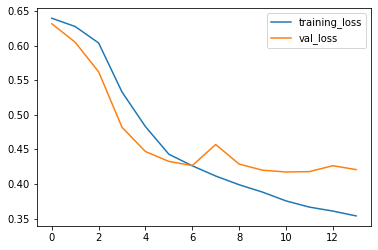

In [107]:
#plot model loss
plt.plot(history_cnn.history['loss'], label = 'training_loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

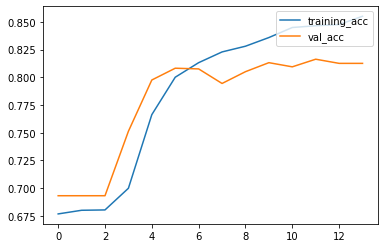

In [108]:
#plot model loss
plt.plot(history_cnn.history['acc'], label = 'training_acc')
plt.plot(history_cnn.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

In [109]:
model_cnn.evaluate(x_test, y_test)

63/63 [==============================] - 0s 6ms/step - loss: 0.4290 - acc: 0.8115


[0.4289551079273224, 0.8115000128746033]

#### 使用CNN (沒有Dropout Layer)

In [70]:
# define model
model_cnn_w = Sequential()
model_cnn_w.add(Embedding(max_words, 64, input_length=maxlen))
model_cnn_w.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model_cnn_w.add(MaxPooling1D(pool_size=2))
model_cnn_w.add(Flatten())
model_cnn_w.add(Dense(10, activation='relu'))
model_cnn_w.add(Dense(1, activation='sigmoid'))
model_cnn_w.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 64)           64000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 193, 32)           16416     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                30730     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 111,157
Trainable params: 111,157
Non-trainable params: 0
________________________________________________

In [71]:
model_cnn_w.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [72]:
history_cnn_w = model_cnn_w.fit(x_train, y_train,
                    epochs=7,
                    batch_size=100,
                    validation_split=0.2)

Epoch 1/7
64/64 [==============================] - 4s 66ms/step - loss: 0.5985 - acc: 0.6803 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 2/7
64/64 [==============================] - 4s 55ms/step - loss: 0.4625 - acc: 0.7919 - val_loss: 0.4624 - val_acc: 0.8000
Epoch 3/7
64/64 [==============================] - 4s 57ms/step - loss: 0.4125 - acc: 0.8409 - val_loss: 0.4454 - val_acc: 0.8087
Epoch 4/7
64/64 [==============================] - 4s 58ms/step - loss: 0.3830 - acc: 0.8542 - val_loss: 0.4458 - val_acc: 0.8087
Epoch 5/7
64/64 [==============================] - 4s 68ms/step - loss: 0.3590 - acc: 0.8712 - val_loss: 0.4465 - val_acc: 0.8087
Epoch 6/7
64/64 [==============================] - 5s 79ms/step - loss: 0.3353 - acc: 0.8811 - val_loss: 0.4517 - val_acc: 0.8081
Epoch 7/7
64/64 [==============================] - 4s 69ms/step - loss: 0.3070 - acc: 0.8984 - val_loss: 0.4688 - val_acc: 0.8200


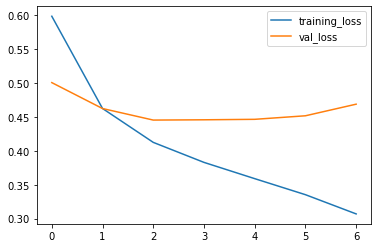

In [73]:
#plot model loss
plt.plot(history_cnn_w.history['loss'], label = 'training_loss')
plt.plot(history_cnn_w.history['val_loss'], label = 'val_loss')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

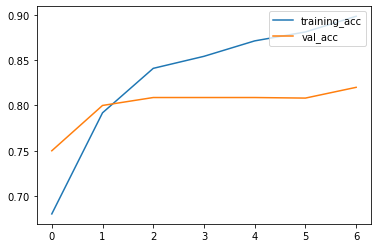

In [74]:
#plot model loss
plt.plot(history_cnn_w.history['acc'], label = 'training_acc')
plt.plot(history_cnn_w.history['val_acc'], label = 'val_acc')
#圖例
plt.legend(loc = 'upper right') 
plt.show()
plt.close()

In [75]:
model_cnn_w.evaluate(x_test, y_test)

63/63 [==============================] - 0s 5ms/step - loss: 0.4707 - acc: 0.8050


[0.4706825017929077, 0.8050000071525574]